In [1]:
from queryFreeSurferMeasures import *
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Specify the filename
fsDb = "/Users/schabdachj/Projects/mpr_analysis/fsResultsNoPreproc.db"
fsPreprocDb = "/Users/schabdachj/Projects/mpr_analysis/fsResultsPreproc.db"

In [3]:
## Load the freesurfer results as a dataframe

assert os.path.exists(fsDb)
assert os.path.exists(fsPreprocDb)

# Connect to the database
cursor, connection = connectToDatabase(fsDb)

# Get a list of ids where one image id is returned per subject
idsStringForQuery, metadataDf = getSingleImageIdPerSubject(cursor)
metadataDf['session_id'] = metadataDf['session_id'].astype(np.int64)
metadataDf = metadataDf.set_index('session_id')

# Get the volumetric metrics for the image ids
measDf = getMeasureStatsAsDf(cursor, idsStringForQuery)

# Close the connection to the database
closeDatabase(connection)

# Convert the dataframes to numeric where relevant
for header in list(measDf):
    measDf[header] = measDf[header].astype(float)

measDf = measDf.infer_objects()
print(measDf.shape)

origDf = metadataDf.join(measDf, on='session_id')
print(list(origDf))

(106, 22)
['subj', 'session', 'run', 'BrainSeg', 'BrainSegNotVent', 'BrainSegNotVentSurf', 'BrainSegVol-to-eTIV', 'CerebralWhiteMatter', 'Cortex', 'EstimatedTotalIntraCranialVol', 'Mask', 'MaskVol-to-eTIV', 'SubCortGray', 'SupraTentorial', 'SupraTentorialNotVent', 'SupraTentorialNotVentVox', 'SurfaceHoles', 'TotalGray', 'VentricleChoroidVol', 'lhCerebralWhiteMatter', 'lhCortex', 'lhSurfaceHoles', 'rhCerebralWhiteMatter', 'rhCortex', 'rhSurfaceHoles']


In [4]:
# Connect to the database
cursor, connection = connectToDatabase(fsPreprocDb)

# Get a list of ids where one image id is returned per subject
idsStringForQuery, metadataDf = getSingleImageIdPerSubject(cursor)
metadataDf['session_id'] = metadataDf['session_id'].astype(np.int64)
metadataDf = metadataDf.set_index('session_id')

# Get the volumetric metrics for the image ids
measPreDf = getMeasureStatsAsDf(cursor, idsStringForQuery)

# Close the connection to the database
closeDatabase(connection)

# Convert the dataframes to numeric where relevant
for header in list(measPreDf):
    measPreDf[header] = measPreDf[header].astype(float)

measPreDf = measPreDf.infer_objects()
print(measPreDf.shape)

## Join the measures and metadata dataframes on session_id (index, but still need to specify)
preprocDf = metadataDf.join(measPreDf, on='session_id')

(62, 22)


In [5]:
## Load the subject ages, sexes, year of scan, and scanner
fn = "/Users/schabdachj/Data/22q11/session_metainfo_27Oct2020.csv"

df = pd.read_csv(fn, encoding='latin-1')
df = df.drop(columns=['Unnamed: 0'])
df = df.drop(index=0)
df = df.infer_objects()
cols = ['SUBJECT_ID', 'DeID.GS.bucket.path', 'SEX', 'Year.of.Study', 'OBJECT_INFO...age_at_imaging_.days.', 'DeviceSerialNumber', 'StationName']
sesMetaDf = df[cols].drop_duplicates()

In [6]:
## Get the folders containing each session in the main df

def getPathFromSession(session):
    
    # Get the session as a subdirectory
    sess = session.split('-')[1]
    
    # Use glob to find the possible subject/DeID paths
    searchStr = "/Users/schabdachj/Data/22q11/sourcedata/22q_*/**/GCPDicom*/"+sess
    paths = glob.glob(searchStr, recursive=True)
    
    # Remove bad paths:
    # - Anyting containing GCPDicom 2+ times
    path = [p for p in paths if p.count("GCPDicom") == 1][0]

    
    # Replace the first part of the path with the path that exists locally
    path = "/".join(path.split('/')[:-1])
    path = path.replace('Users/schabdachj/Data/22q11/sourcedata', '22q_dev2020July_DeID')
    
    return path

    
origDf['DeID.GS.bucket.path'] = [getPathFromSession(ses) for ses in origDf['session']]
preprocDf['DeID.GS.bucket.path'] = [getPathFromSession(ses) for ses in preprocDf['session']]

In [7]:
## Join mainDf and sesMetaDf

origDf = origDf.reset_index()
origDf = origDf.merge(sesMetaDf.reset_index(), on='DeID.GS.bucket.path').dropna()
print(origDf.shape)

preprocDf = preprocDf.reset_index()
preprocDf = preprocDf.merge(sesMetaDf.reset_index(), on='DeID.GS.bucket.path').dropna()
print(preprocDf.shape)

print(list(origDf))
print(list(preprocDf))

(106, 34)
(62, 34)
['session_id', 'subj', 'session', 'run', 'BrainSeg', 'BrainSegNotVent', 'BrainSegNotVentSurf', 'BrainSegVol-to-eTIV', 'CerebralWhiteMatter', 'Cortex', 'EstimatedTotalIntraCranialVol', 'Mask', 'MaskVol-to-eTIV', 'SubCortGray', 'SupraTentorial', 'SupraTentorialNotVent', 'SupraTentorialNotVentVox', 'SurfaceHoles', 'TotalGray', 'VentricleChoroidVol', 'lhCerebralWhiteMatter', 'lhCortex', 'lhSurfaceHoles', 'rhCerebralWhiteMatter', 'rhCortex', 'rhSurfaceHoles', 'DeID.GS.bucket.path', 'index', 'SUBJECT_ID', 'SEX', 'Year.of.Study', 'OBJECT_INFO...age_at_imaging_.days.', 'DeviceSerialNumber', 'StationName']
['session_id', 'subj', 'session', 'run', 'BrainSeg', 'BrainSegNotVent', 'BrainSegNotVentSurf', 'BrainSegVol-to-eTIV', 'CerebralWhiteMatter', 'Cortex', 'EstimatedTotalIntraCranialVol', 'Mask', 'MaskVol-to-eTIV', 'SubCortGray', 'SupraTentorial', 'SupraTentorialNotVent', 'SupraTentorialNotVentVox', 'SurfaceHoles', 'TotalGray', 'VentricleChoroidVol', 'lhCerebralWhiteMatter', 'l

# Histograms of Metrics

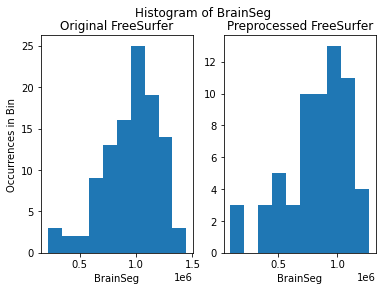

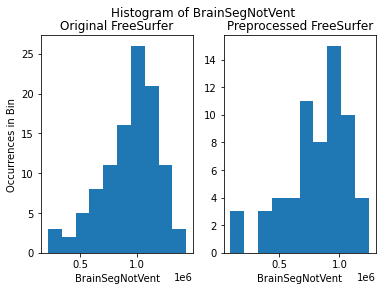

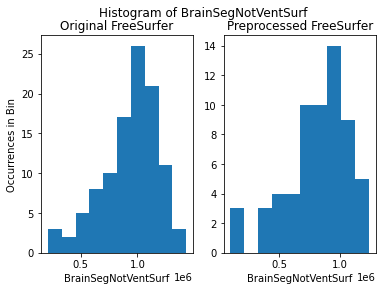

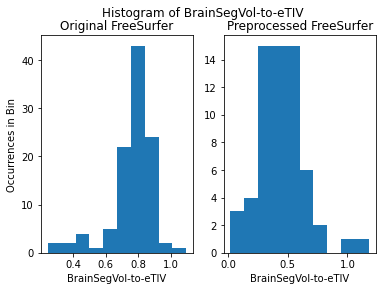

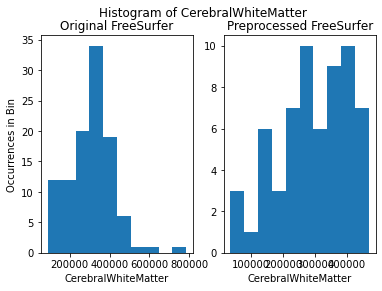

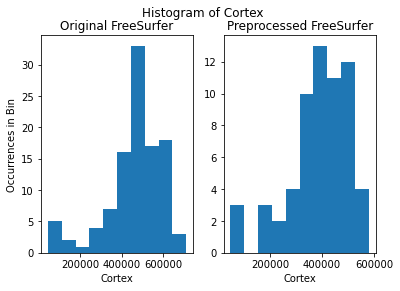

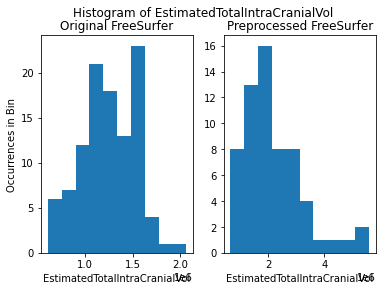

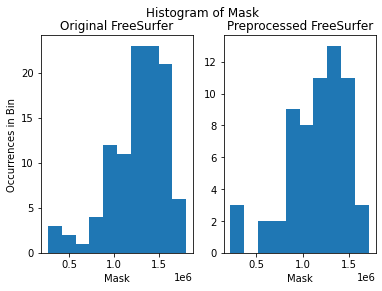

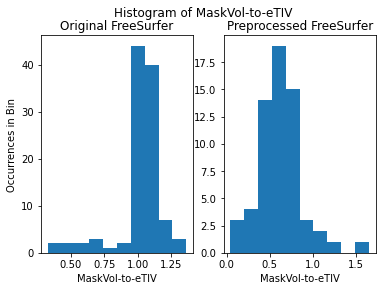

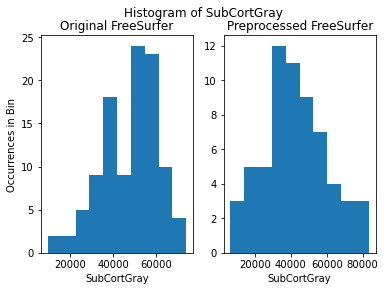

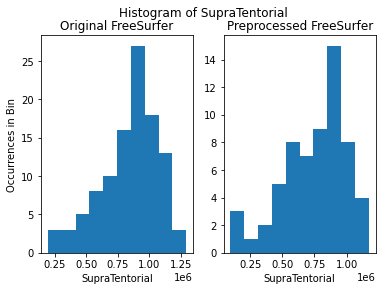

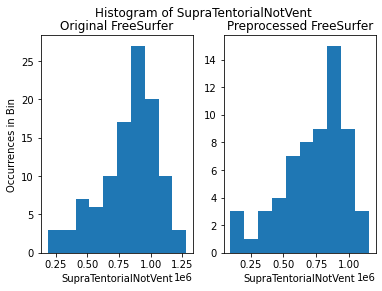

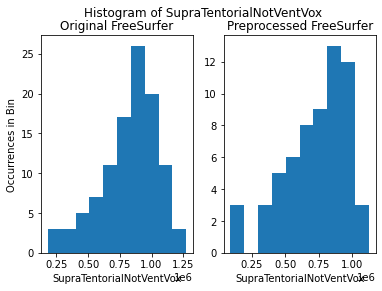

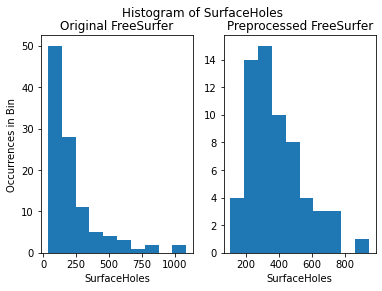

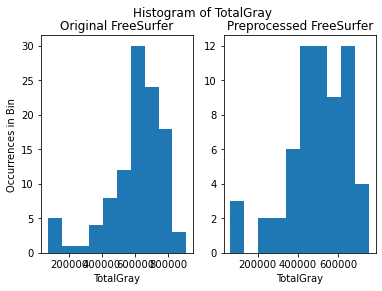

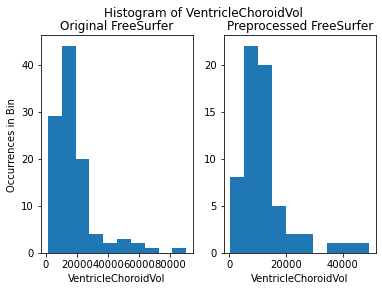

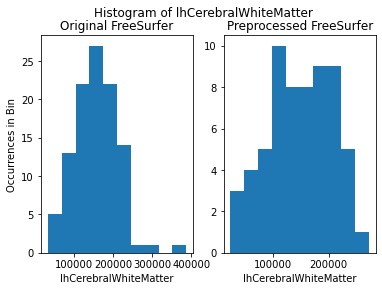

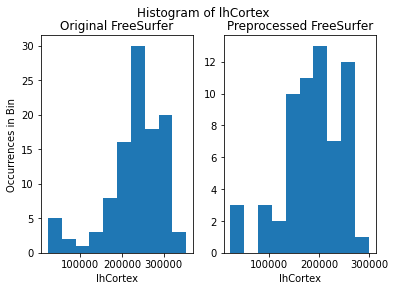

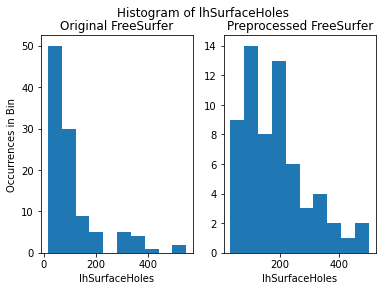

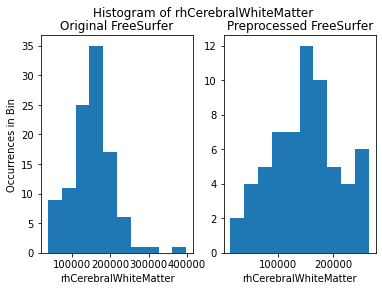

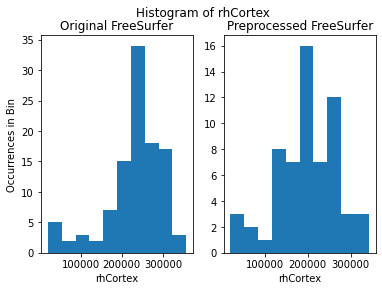

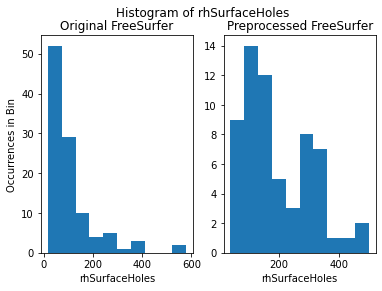

In [8]:
def plotMetricHist(metricList, label, subtitles=[]):

    if len(metricList) == 1:
        plt.figure()
        plt.hist(metricList[0])
        plt.xlabel(label)
        plt.ylabel('Occurrences in Bin')
        
    elif len(metricList) < 4:
        fig, axs = plt.subplots(1, len(metricList))
        for i in range(len(metricList)):
            axs[i].hist(metricList[i])
            axs[i].set_title(subtitles[i])
        
        plt.setp(axs, xlabel=label)
        plt.setp(axs[0], ylabel='Occurrences in Bin')
        
    plt.suptitle("Histogram of "+label)    
    plt.show()
        
for c in list(measPreDf):
    plotMetricHist([origDf[c].astype(float), preprocDf[c].astype(float)], c, 
                   ["Original FreeSurfer", "Preprocessed FreeSurfer"])

# Regression: Metric vs. Age at Scan

In [9]:
list(origDf)

['session_id',
 'subj',
 'session',
 'run',
 'BrainSeg',
 'BrainSegNotVent',
 'BrainSegNotVentSurf',
 'BrainSegVol-to-eTIV',
 'CerebralWhiteMatter',
 'Cortex',
 'EstimatedTotalIntraCranialVol',
 'Mask',
 'MaskVol-to-eTIV',
 'SubCortGray',
 'SupraTentorial',
 'SupraTentorialNotVent',
 'SupraTentorialNotVentVox',
 'SurfaceHoles',
 'TotalGray',
 'VentricleChoroidVol',
 'lhCerebralWhiteMatter',
 'lhCortex',
 'lhSurfaceHoles',
 'rhCerebralWhiteMatter',
 'rhCortex',
 'rhSurfaceHoles',
 'DeID.GS.bucket.path',
 'index',
 'SUBJECT_ID',
 'SEX',
 'Year.of.Study',
 'OBJECT_INFO...age_at_imaging_.days.',
 'DeviceSerialNumber',
 'StationName']

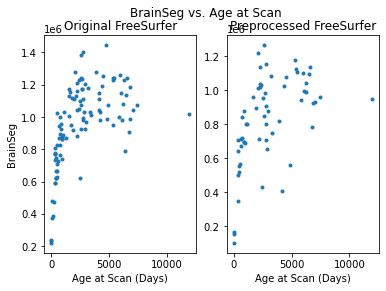

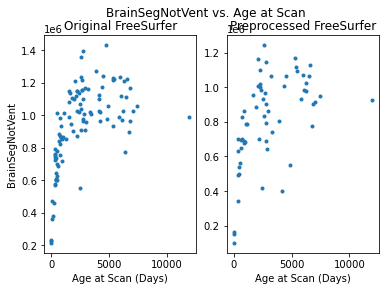

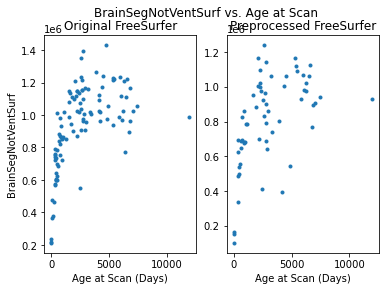

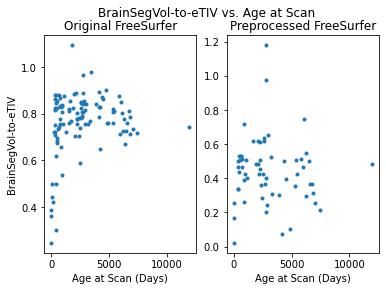

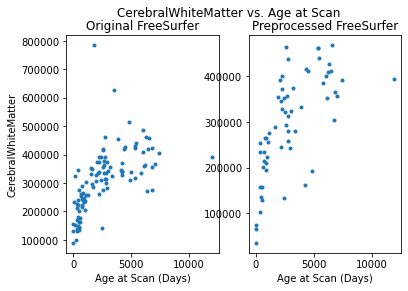

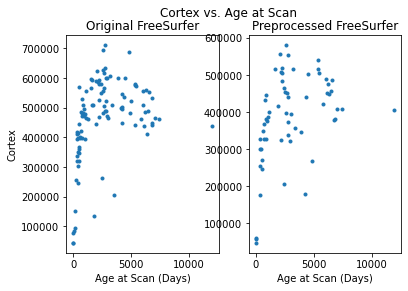

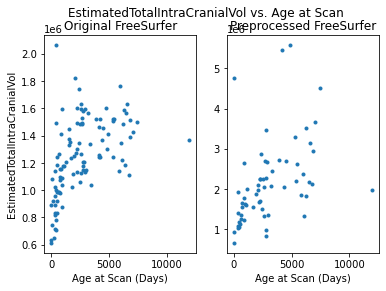

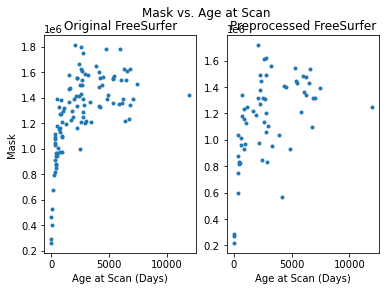

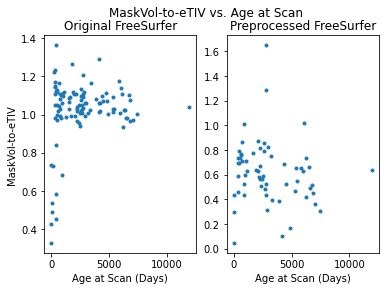

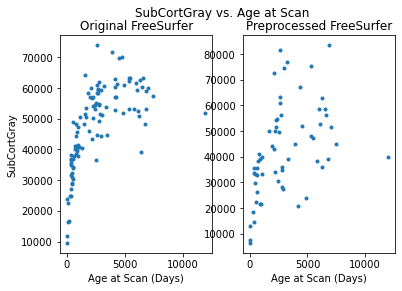

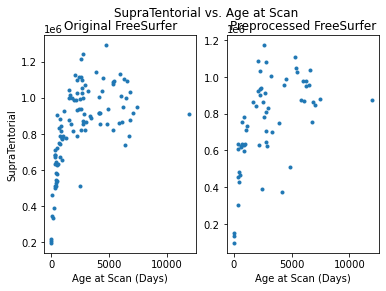

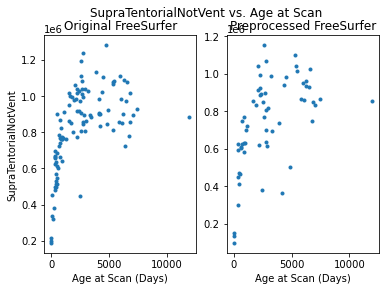

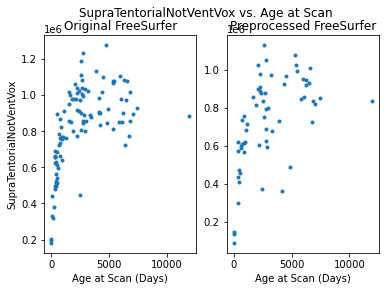

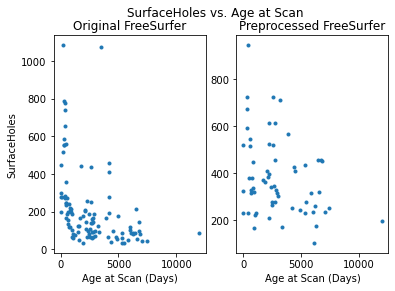

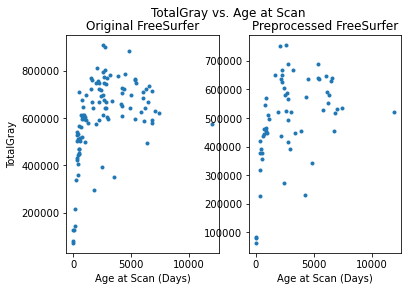

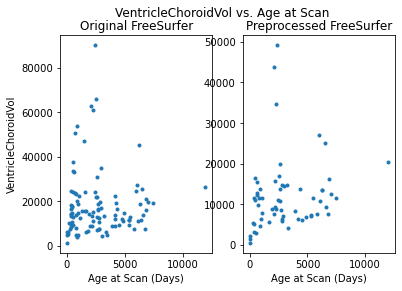

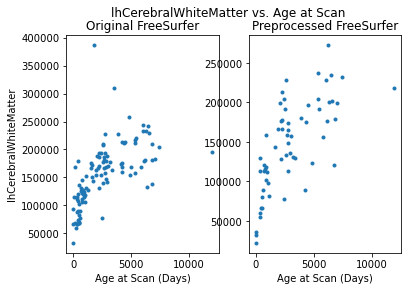

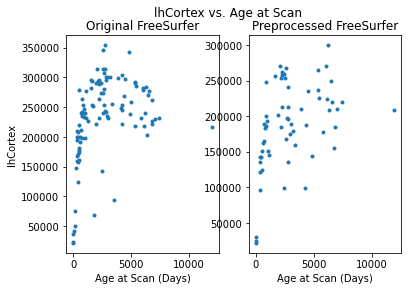

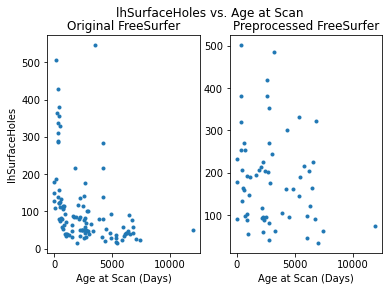

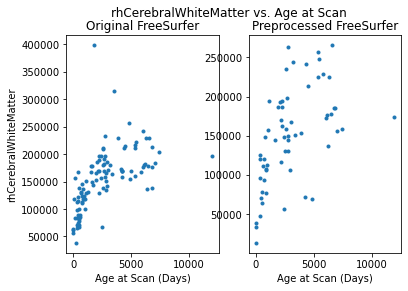

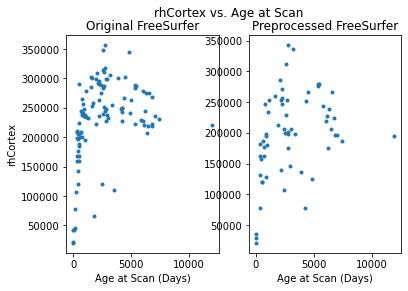

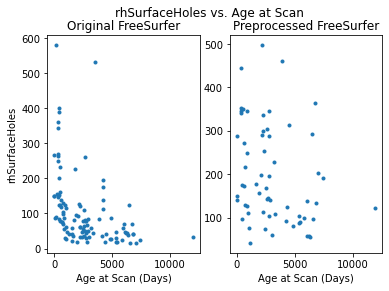

In [14]:
def plotMetricVsAge(metricList, ageList, label, subtitles):
    
    if len(metricList) == 1:
        plt.figure()
        plt.plot(age, metric, '.')
        plt.xlabel("Age at Scan (Days)")
        plt.ylabel(label)
        
    elif len(metricList) < 4:
        fig, axs = plt.subplots(1, len(metricList))
        for i in range(len(metricList)):
            axs[i].plot(ageList[i], metricList[i], '.')
            axs[i].set_title(subtitles[i])
        
        plt.setp(axs, xlabel="Age at Scan (Days)")
        plt.setp(axs[0], ylabel=label)
        
    plt.suptitle(label+" vs. Age at Scan")
    plt.show()
        
for c in list(measPreDf):
    plotMetricVsAge([origDf[c].astype(float), preprocDf[c].astype(float)],
                    [origDf['OBJECT_INFO...age_at_imaging_.days.'], preprocDf['OBJECT_INFO...age_at_imaging_.days.']], 
                    c,
                    ["Original FreeSurfer", "Preprocessed FreeSurfer"])

# Before and after preprocessing

# Example Regression: Brain Volume vs. Age

In [ ]:
list(mainDf)

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_validate

from sklearn.metrics import mean_squared_error, r2_score

# Convert SEX column into a dichotomous variable
mainDf['isMale'] = np.where(mainDf['SEX']!= 'M', 1, 0)
mainDf['age2'] = mainDf['OBJECT_INFO...age_at_imaging_.days.']**2

X = mainDf[['OBJECT_INFO...age_at_imaging_.days.', 'age2', 'isMale', 'SurfaceHoles']]
y = mainDf['TotalGray']

X = mainDf[mainDf['OBJECT_INFO...age_at_imaging_.days.'] > 1095][['OBJECT_INFO...age_at_imaging_.days.', 'age2', 'isMale']] #'SurfaceHoles']]
y = mainDf[mainDf['OBJECT_INFO...age_at_imaging_.days.'] > 1095]['TotalGray']

# Create an instance of the linear regression model
model = LinearRegression()

# # N-fold cross validation
# cv_results = cross_validate(model, X, y,
#                             scoring=('r2', 'neg_mean_squared_error', 'explained_variance'))

# Split the feature and class pairs intotraining and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Train the model
model.fit(X, y)

# Test the model
predictions = model.predict(X)

# Compare the predictions to the actual values
# Root mean squared error - lower is better
rmse = (np.sqrt(mean_squared_error(y, predictions)))
# r squared - closer to 1 is better
r2 = r2_score(y, predictions)

print(rmse)
print(r2)

def plotRegressionPredictions(x, y, pred):
    # Plot a figure 
    plt.figure()
    plt.scatter(x, y, c='b')
    plt.scatter(x, predictions, c='r', marker='+')

    # add the regression line
    reg_x = np.linspace(min(x),
                        max(x),
                        x.shape[0]-1)
    # plt.plot(reg_x, reg_x*model.coef_[)

    plt.xlabel('Age at Scan (Days)')
    plt.ylabel('Total Gray Volume')
    plt.title('Predicted Gray Matter Volume')
    plt.show()

    
plotRegressionPredictions(X['OBJECT_INFO...age_at_imaging_.days.'], y, predictions)

print(min(X['OBJECT_INFO...age_at_imaging_.days.']))
print(max(X['OBJECT_INFO...age_at_imaging_.days.']))

print(model.coef_)

In [ ]:
peds = mainDf[mainDf['OBJECT_INFO...age_at_imaging_.days.'] > 1095]
peds[(peds['OBJECT_INFO...age_at_imaging_.days.'] < 4000) & (peds['TotalGray'] < 500000)][['subj', 'SurfaceHoles', 'OBJECT_INFO...age_at_imaging_.days.', 'SEX' ]]

In [ ]:
residuals = np.abs(y - predictions)
plt.figure()
plt.hist(residuals)

yq = peds[peds['subj'] == 'sub-22q0172']['TotalGray'].values[0]
print(yq)
idx = list(y.values).index(yq)
resid = (abs(yq-predictions[idx]))
print(predictions[idx])

print(resid/yq)
print(resid/predictions[idx])

In [ ]:
np.multiply